# Set-up

In [70]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Data Investigation

In [44]:
# Read data from the file
orders = pd.read_excel("online_retail_II.xlsx",
                      sheet_name = "Year 2010-2011")

In [31]:
orders.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [32]:
# check basic info about the orders data
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [35]:
# descriptive statistics of non
orders.describe()

,Quantity,Price
count,406830.000000,406830.000000
mean,12.061276,3.460507
std,248.693065,69.315080
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [36]:
# check what is causing negative quantity in purchace
orders[orders["Quantity"] <=  0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


# Data Processing
1. Need to filter out orders with missing ID
2. Need to cut the cancelled orders from the data set

In [165]:
# filter orders that has no customer ID
orders.dropna(subset=['Customer ID'], inplace=True)

# filter out cancelled orders
orders = orders[orders["Quantity"] > 0]

# Calculate the total transaction amount
orders["TotalAmount"] = orders["Quantity"] * orders["Price"]

In [166]:
# change data types
# using dictionary to convert specific columns
convert_dict = {'Customer ID': int,
                'InvoiceDate': str
                }
orders = orders.astype(convert_dict)

# convert data type of Invoice Date
orders['InvoiceDate'] = pd.to_datetime(orders['InvoiceDate'].astype(str), format='%Y/%m/%d')
orders['Customer ID'] =  orders['Customer ID'].astype(str)

print(orders.dtypes)

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
TotalAmount           float64
dtype: object


# RFM Metrics Extraction

In [48]:
max_date = orders["InvoiceDate"].max()
print(max_date)

2011-12-09 12:50:00


In [167]:
rfm = orders.groupby("Customer ID").agg({'InvoiceDate': lambda date: (max_date - date.max()).days,
                                         'Invoice': lambda num: len(set(num)),
                                         'TotalAmount': lambda price: price.sum()})
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,325,1,77183.60
12347,1,7,4310.00
12348,74,4,1797.24
12349,18,1,1757.55
12350,309,1,334.40


In [168]:
rfm.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,91.518322,4.271952,2053.797166
std,100.009747,7.705493,8988.247836
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,307.245000
50%,50.000000,2.000000,674.450000
75%,141.000000,5.000000,1661.640000
max,373.000000,210.000000,280206.020000


# RFM Score Calculation

In [173]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])

rfm["RFM_Score"] = (rfm["R_Score"].astype(str)+
                    rfm["F_Score"].astype(str))

convert_dict = {'R_Score': int,
                'F_Score': int,
                'M_Score': int
               }

rfm = rfm.astype(convert_dict)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346,325,1,77183.60,1,1,5,11
12347,1,7,4310.00,5,5,5,55
12348,74,4,1797.24,2,4,4,24
12349,18,1,1757.55,4,1,4,41
12350,309,1,334.40,1,1,2,11


## RFM Attributes Visualization

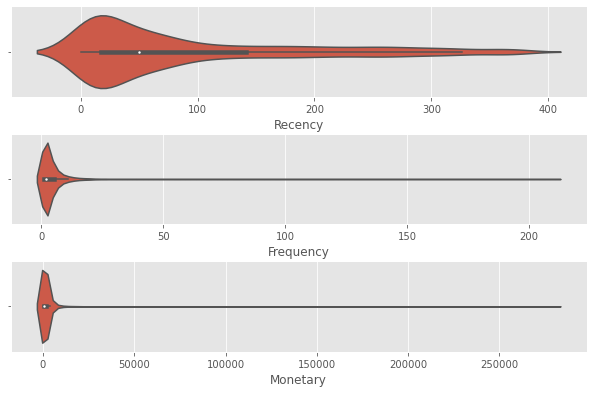

In [246]:
# Initialise the subplot function using number of rows and columns
fig, axs = plt.subplots(3, 1,figsize = (10, 6))

to_plot = ["Recency","Frequency","Monetary"]
for i in range(3):
    sns.violinplot(x=to_plot[i], data=rfm,ax=axs[i])
    axs[i].set(xlabel=to_plot[i])
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

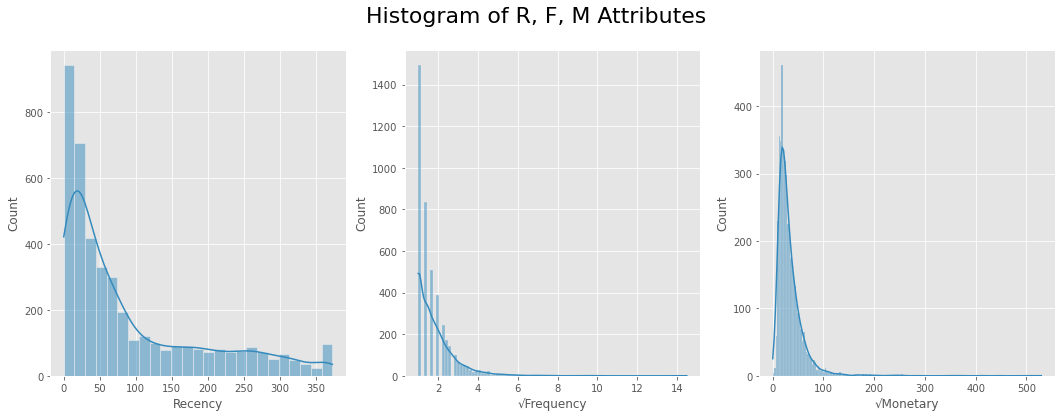

In [293]:
# Initialise the subplot function using number of rows and columns
fig, axs = plt.subplots(1, 3,figsize = (18, 6))

sns.histplot(data=rfm, x="Recency", kde=True, ax=axs[0])
axs[0].set(xlabel="Recency")

sns.histplot(x=rfm["Frequency"]**0.5, kde=True, ax=axs[1])
axs[1].set(xlabel=u"\u221A""Frequency")

sns.histplot(x=rfm["Monetary"]**0.5, kde=True, ax=axs[2])
axs[2].set(xlabel=u"\u221A""Monetary")

plt.suptitle("Histogram of R, F, M Attributes", fontsize=22)

# Show the plot
plt.savefig("RFM_Raw.png")

plt.show()

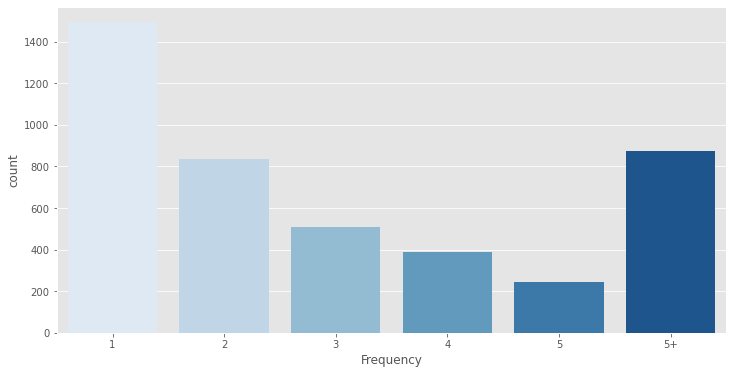

In [283]:
f_bins = [0,1,2,3,4,5, float('inf')]
fig = plt.figure(figsize = (12, 6))
ax = sns.countplot(x=pd.cut(x=rfm["Frequency"],bins=f_bins).apply(lambda x: int(x.left)),
                  palette="Blues")
ax.set(xticks=[0,1,2,3,4,5], xticklabels=[1,2,3,4,5,"5+"])
plt.show()

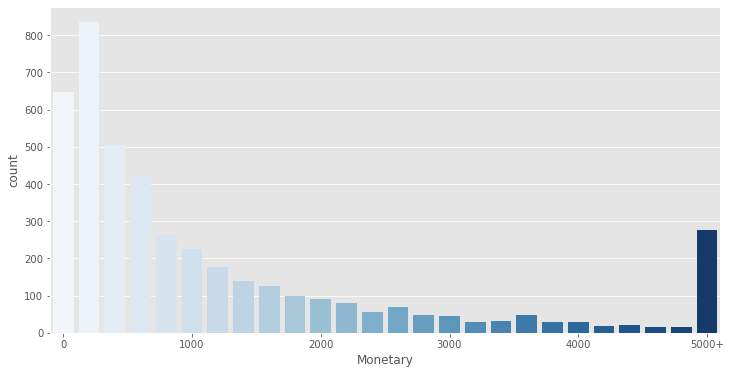

In [287]:
m_bins = [i for i in range(0,5000,200)] + [5000, float('inf')]
fig = plt.figure(figsize = (12, 6))
ax = sns.countplot(x=pd.cut(x=rfm["Monetary"],bins=m_bins).apply(lambda x: int(x.left)),
                   palette="Blues")
ax.set(xticks=[0,5,10,15,20,25], xticklabels=[0,1000,2000,3000,4000,"5000+"])
plt.show()

# Define Customer Segments

In [295]:
# Classifiying Segments based on the RFM Score
seg_dict = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Can\'t_lose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_attention',
    r'[3-4][4-5]': 'Loyal_customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['RFM_Score'].replace(seg_dict, regex=True)
rfm['Count'] = 1
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Count
Customer ID,,,,,,,,,
12346,325,1,77183.60,1,1,5,11,Hibernating,1
12347,1,7,4310.00,5,5,5,55,Champions,1
12348,74,4,1797.24,2,4,4,24,At_Risk,1
12349,18,1,1757.55,4,1,4,41,Promising,1
12350,309,1,334.40,1,1,2,11,Hibernating,1


In [298]:
# Pivoting for data Visualization
seg_df = rfm.groupby("Segment").agg({'R_Score': lambda s: s.mean(),
                                    'F_Score': lambda s: s.mean(),
                                    'M_Score': lambda s: s.mean(),
                                    'Monetary': lambda s:s.mean(),
                                    'Count': lambda s:len(s)})
seg_df = seg_df.reset_index()
seg_df

,Segment,R_Score,F_Score,M_Score,Monetary,Count
0,About_to_Sleep,3.000000,1.532764,2.039886,461.061510,351
1,At_Risk,1.674138,3.367241,3.020690,1076.506433,580
2,Can't_lose,1.809524,5.000000,4.301587,2796.155873,63
3,Champions,5.000000,4.693523,4.459716,6857.963918,633
4,Hibernating,1.376526,1.472300,1.861033,487.707579,1065
5,Loyal_customers,3.611850,4.442563,4.140266,2856.720328,827
6,Need_attention,3.000000,3.000000,2.870968,889.226398,186
7,New_Customers,5.000000,1.000000,1.714286,388.212857,42
8,Potential_Loyalists,4.392276,2.638211,2.603659,1034.905467,492
9,Promising,4.000000,1.000000,1.620000,351.797800,100


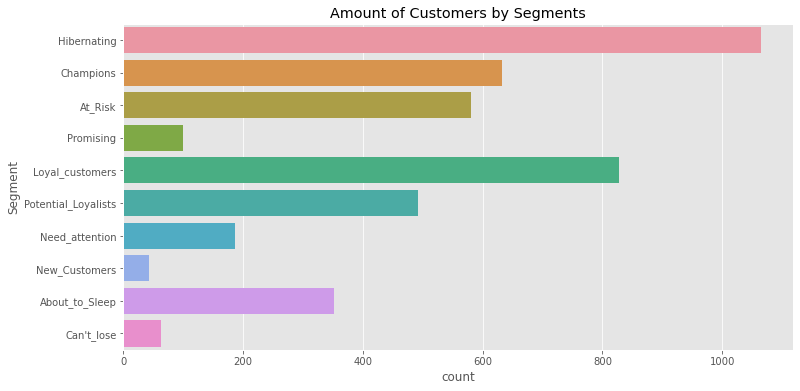

In [176]:
# Overview of 
fig = plt.figure(figsize = (12, 6))

# count plot on single categorical variable
ax = sns.countplot(y ='Segment', data = rfm)

plt.title("Amount of Customers by Segments")

# Show the plot
plt.savefig("Segments_Count.png")
plt.show()

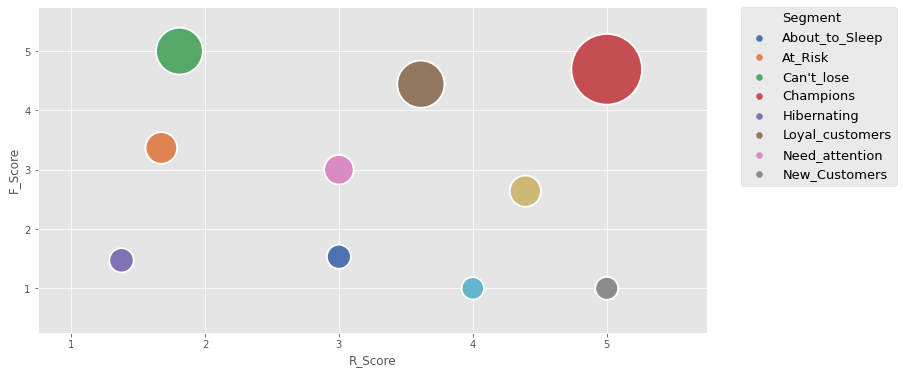

In [177]:
fig = plt.figure(figsize = (12, 6))

g = sns.scatterplot(data=seg_df, 
                x="R_Score", y="F_Score", 
                size="Monetary", sizes=(500, 5000),
                hue="Segment", palette="deep"
               )

g.set_xlim(0.75,5.75)
g.set_ylim(0.25,5.75)

h,l = g.get_legend_handles_labels()
plt.legend(h[0:9],l[0:9],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
plt.show(g)

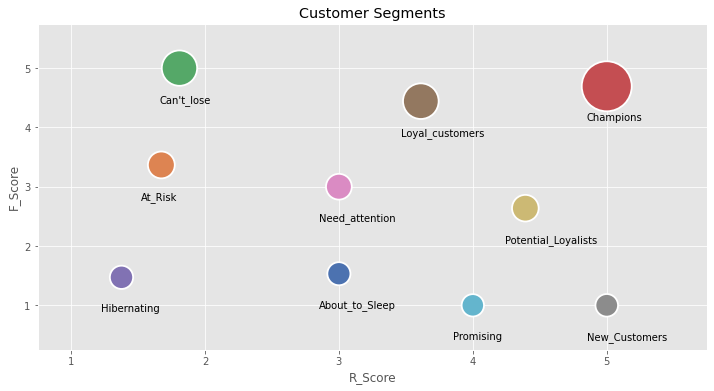

In [179]:
# Alternative Format of Viz.
plt.style.use('ggplot')
fig = plt.figure(figsize = (12, 6))

g = sns.scatterplot(data=seg_df, 
                x="R_Score", y="F_Score", 
                size="Monetary", sizes=(500, 2500),
                hue="Segment", palette="deep", legend = False
               )

g.set_xlim(0.75,5.75)
g.set_ylim(0.25,5.75)

x,y = seg_df['R_Score'], seg_df['F_Score']
labels = seg_df['Segment']
for i, txt in enumerate(labels):
    g.annotate(txt, (x[i]-0.15, y[i]-0.575))
    
plt.title("Customer Segments")

plt.savefig("Segments_M.png")
plt.show()